## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, precision_score, recall_score
from random import sample
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix, precision_score, f1_score

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
70680,00017425_004.png,Cardiomegaly|Edema|Mass,4,17425,12,F,AP,2500,2048,0.168000,0.168000,NaN,/data/images_008/images/00017425_004.png
88055,00021782_022.png,No Finding,22,21782,35,F,PA,1755,1843,0.194311,0.194311,NaN,/data/images_010/images/00021782_022.png
6568,00001762_001.png,No Finding,1,1762,61,F,PA,2048,2500,0.168000,0.168000,NaN,/data/images_002/images/00001762_001.png


In [4]:
# Drop NaN column Unnamed: 11
all_xray_df = all_xray_df.drop(columns = ['Unnamed: 11'])
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'path'],
      dtype='object')

In [5]:
# Unpack the disease labels from the 'Finding Labels' column
disease_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
disease_labels = [x for x in disease_labels if len(x)>0]
print('Disease Labels ({}): {}'.format(len(disease_labels), disease_labels))
for c_label in disease_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.sample(10)

Disease Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
57778,00014318_000.png,No Finding,0,14318,68,M,PA,2992,2991,0.143000,...,0,0,0,0,0,1,0,0,0,0
108202,00029289_001.png,No Finding,1,29289,44,F,PA,2021,2021,0.194311,...,0,0,0,0,0,1,0,0,0,0
84936,00020937_000.png,No Finding,0,20937,67,M,PA,2566,2833,0.143000,...,0,0,0,0,0,1,0,0,0,0
19344,00005124_003.png,No Finding,3,5124,48,F,AP,2500,2048,0.171000,...,0,0,0,0,0,1,0,0,0,0
57435,00014251_009.png,Infiltration,9,14251,68,M,PA,2500,2048,0.168000,...,0,0,0,1,0,0,0,0,0,0
53228,00013443_008.png,No Finding,8,13443,20,M,PA,2992,2991,0.143000,...,0,0,0,0,0,1,0,0,0,0
74875,00018366_035.png,No Finding,35,18366,64,F,PA,2598,2991,0.143000,...,0,0,0,0,0,1,0,0,0,0
16129,00004313_000.png,No Finding,0,4313,37,F,AP,2500,2048,0.168000,...,0,0,0,0,0,1,0,0,0,0
83097,00020408_070.png,No Finding,70,20408,46,M,AP,3056,2544,0.139000,...,0,0,0,0,0,1,0,0,0,0
2155,00000568_000.png,No Finding,0,568,35,M,AP,2500,2048,0.168000,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# Drop the outlier data with Patient Age > 110
all_xray_df[all_xray_df['Patient Age'] > 110]
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 110]
len(all_xray_df)

112104

In [11]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


In [7]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: '1' if x == 1.0 else '0').astype(str)


In [7]:
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'path', 'Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
       'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'pneumonia_class'],
      dtype='object')

## Create your training and testing data:

In [8]:
def create_splits(xray_df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia

    
    train_data, val_data = skl.train_test_split(xray_df, 
                        test_size = 0.2,
                        random_state = 3,
                        stratify = xray_df['pneumonia_class'])

    # Create a balanced training dataset from positive and negative pneumonia cases
    p_inds = train_data[train_data.pneumonia_class=='1'].index.tolist()
    np_inds = train_data[train_data.pneumonia_class=='0'].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]

    # Create a validation dataset from positive and negative pneumonia cases
    p_inds = val_data[val_data.pneumonia_class=='1'].index.tolist()
    np_inds = val_data[val_data.pneumonia_class=='0'].index.tolist()

    np_sample = sample(np_inds,5 * len(p_inds))
    val_data = val_data.loc[p_inds + np_sample]
    
    return train_data, val_data

In [9]:
train_data, val_data = create_splits(all_xray_df)

In [10]:
# Verify gender distribution 
print(train_data['Patient Gender'].value_counts())
print(val_data['Patient Gender'].value_counts())
print(all_xray_df['Patient Gender'].value_counts())

M    1355
F     933
Name: Patient Gender, dtype: int64
M    977
F    739
Name: Patient Gender, dtype: int64
M    63328
F    48776
Name: Patient Gender, dtype: int64


We find that gender distribution has similar proportions in the training, validation and overall datasets

In [11]:
# Verify View Position 
print(train_data['View Position'].value_counts())
print(val_data['View Position'].value_counts())
print(all_xray_df['View Position'].value_counts())

PA    1185
AP    1103
Name: View Position, dtype: int64
PA    976
AP    740
Name: View Position, dtype: int64
PA    67299
AP    44805
Name: View Position, dtype: int64


 We find that View Position distribution is more balanced in the training dataset

In [ ]:
# Verify Age distribution
plt.hist(train_data['Patient Age'], bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Training data age distribution')

We see from the above that our algorithm will be defined for use for patients in the range of 0-90
But intended for use from ages 30-70 where we have the most training cases

Text(0.5, 1.0, 'Validation data age distribution')

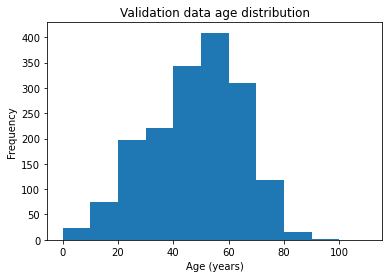

In [19]:
plt.hist(val_data['Patient Age'], bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Validation data age distribution')

In [16]:
# Let us also check gender distribution in this age range
train_data[(train_data['Patient Age'] >= 30) & (train_data['Patient Age'] <= 70)]['Patient Gender'].value_counts()

M    975
F    765
Name: Patient Gender, dtype: int64

In [13]:
# Let us also check view position distribution in this age range
train_data[(train_data['Patient Age'] >= 30) & (train_data['Patient Age'] <= 70)]['View Position'].value_counts()

PA    905
AP    796
Name: View Position, dtype: int64

In [14]:
# Let us also check view position distribution for males in this age range
train_data[(train_data['Patient Age'] >= 30) & (train_data['Patient Age'] <= 70) & (train_data['Patient Gender'] == 'M')]['View Position'].value_counts()

PA    518
AP    475
Name: View Position, dtype: int64

In [15]:
# Let us also check view position distribution for females in this age range
train_data[(train_data['Patient Age'] >= 30) & (train_data['Patient Age'] <= 70) & (train_data['Patient Gender'] == 'F')]['View Position'].value_counts()

PA    387
AP    321
Name: View Position, dtype: int64

Female to male ratio is ~44/56. So we are training slightly more on the male population

Text(0, 0.5, 'Frequency')

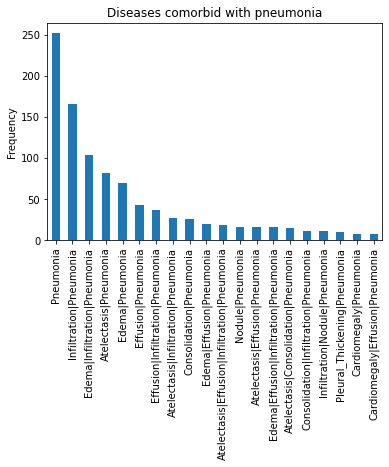

In [17]:
# Diseases comorbid with pneumonia
train_data[train_data.Pneumonia == 1]['Finding Labels'].value_counts()[0:20].plot(kind='bar')
plt.title('Diseases comorbid with pneumonia')
plt.ylabel('Frequency')

In [20]:
# Let us also check gender distribution in this age range
val_data[(val_data['Patient Age'] >= 30) & (val_data['Patient Age'] <= 70)]['Patient Gender'].value_counts()

M    716
F    584
Name: Patient Gender, dtype: int64

In [21]:
# Let us also check view position distribution in this age range
val_data[(val_data['Patient Age'] >= 30) & (val_data['Patient Age'] <= 70)]['View Position'].value_counts()

PA    760
AP    540
Name: View Position, dtype: int64

In [22]:
# Let us also check view position distribution for males in this age range
val_data[(val_data['Patient Age'] >= 30) & (val_data['Patient Age'] <= 70) & (val_data['Patient Gender'] == 'M')]['View Position'].value_counts()

PA    399
AP    317
Name: View Position, dtype: int64

In [23]:
# Let us also check view position distribution for females in this age range
val_data[(val_data['Patient Age'] >= 30) & (val_data['Patient Age'] <= 70) & (val_data['Patient Gender'] == 'F')]['View Position'].value_counts()

PA    361
AP    223
Name: View Position, dtype: int64

Text(0, 0.5, 'Frequency')

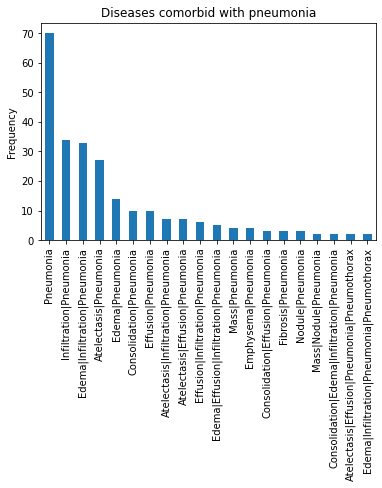

In [24]:
# Diseases comorbid with pneumonia
val_data[val_data.Pneumonia == 1]['Finding Labels'].value_counts()[0:20].plot(kind='bar')
plt.title('Diseases comorbid with pneumonia')
plt.ylabel('Frequency')

In [17]:
#Final check before training: are any patients repeated in the training and validation datasets?
ids_train_set = set(train_data['Patient ID'].values)
ids_val_set = set(val_data['Patient ID'].values)

patient_overlap = list(ids_train_set.intersection(ids_val_set))
n_overlap = len(patient_overlap)

print ('Unique and total patients in training data')
print (len(ids_train_set))
print (len(train_data))

print ('Unique and total patients in validation data')
print (len(ids_val_set))
print (len(val_data))

print ('Unique and total patients in all data')
print (len(set(all_xray_df['Patient ID'].values)))
print (len(all_xray_df))


Unique and total patients in training data
1773
2288
Unique and total patients in validation data
1520
1716
Unique and total patients in all data
30802
112104


In [9]:
# Final check
train_data.pneumonia_class.nunique()

2

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [10]:
def my_image_augmentation(vargs):
    
    # we will scale here by the sample wise image mean and std dev, and so divide by 255 is not essential
    my_idg = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,    
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.3],
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False)
    
    return my_idg


def make_train_gen(vargs):
    
    datagen =  my_image_augmentation('train')
    train_gen = datagen.flow_from_dataframe(dataframe=train_data,
                                            directory = None,
                                            x_col = 'path',
                                            y_col = 'pneumonia_class',
                                            class_mode = 'binary',
                                            target_size = (224,224),
                                            batch_size = 64
                                           )
    
    return train_gen


def make_val_gen(vargs):
    
    # We will scale here by the image mean and std dev of training data (sample) 
    train_gen_stats = ImageDataGenerator().flow_from_dataframe(dataframe=train_data,
                                                               directory = None,
                                                               x_col = 'path',
                                                               y_col = 'pneumonia_class',
                                                               class_mode = 'binary',
                                                               target_size = (224,224),
                                                               batch_size = 64)
    
    # get training data sample
    batch = train_gen_stats.next()
    data_sample = batch[0]

    # use training sample to fit mean and std for validation set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get validation generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe = val_data,
            directory = None,
            x_col = 'path',
            y_col = 'pneumonia_class',
            class_mode = 'binary',
            batch_size = 64,
            target_size = (224,224))

    return valid_generator

In [9]:
val_data['pneumonia_class'].value_counts()

0    1430
1     286
Name: pneumonia_class, dtype: int64

In [11]:
val_gen = make_val_gen('validation')

Found 2288 validated image filenames belonging to 2 classes.
Found 1716 validated image filenames belonging to 2 classes.


Found 2288 validated image filenames belonging to 2 classes.


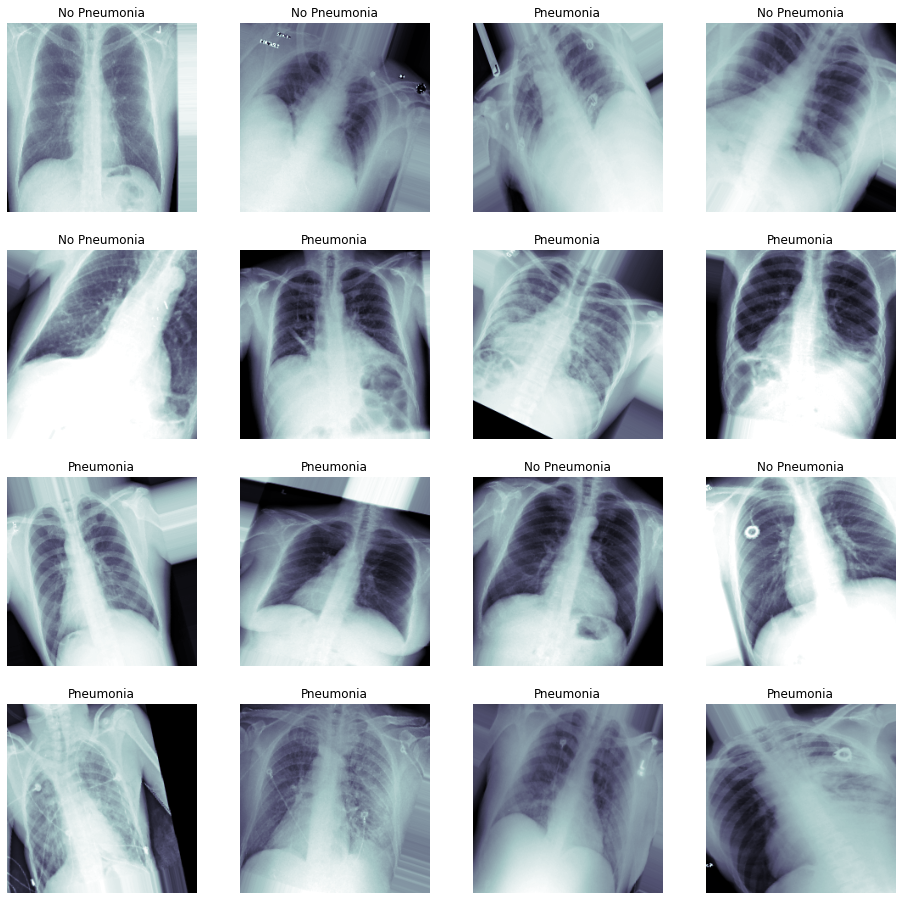

In [12]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

train_gen = make_train_gen('train')
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [13]:
def load_pretrained_model(vargs):
    
    model = VGG16(include_top=True, weights='imagenet')
    
    transfer_layer = model.get_layer('block5_pool')
    
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model


In [16]:
def build_my_model(vargs):
    
    vgg_model = load_pretrained_model('VGG16')
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    my_model = Sequential()
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.2))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.2))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return my_model

In [17]:
model = build_my_model('VGG16')
model.summary()

553467904/553467096 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_____________________________________________________

In [18]:
# Adding checkpoints to save the best model based on minimum validation loss

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [19]:
# We will monitor metrics on the entire validation data
history = model.fit_generator(train_gen,
                              validation_data = val_gen,
                              epochs = 12,
                              callbacks = callbacks_list)

Epoch 1/12
36/36 [==============================] - 99s 3s/step - loss: 0.7287 - binary_accuracy: 0.5293 - val_loss: 0.6901 - val_binary_accuracy: 0.5227

Epoch 00001: val_loss improved from inf to 0.69011, saving model to xray_class_my_model.best.hdf5
Epoch 2/12
36/36 [==============================] - 68s 2s/step - loss: 0.6732 - binary_accuracy: 0.5927 - val_loss: 0.7193 - val_binary_accuracy: 0.5670

Epoch 00002: val_loss did not improve from 0.69011
Epoch 3/12
36/36 [==============================] - 70s 2s/step - loss: 0.6701 - binary_accuracy: 0.5983 - val_loss: 0.7496 - val_binary_accuracy: 0.5303

Epoch 00003: val_loss did not improve from 0.69011
Epoch 4/12
36/36 [==============================] - 70s 2s/step - loss: 0.6544 - binary_accuracy: 0.6158 - val_loss: 0.6161 - val_binary_accuracy: 0.6643

Epoch 00004: val_loss improved from 0.69011 to 0.61607, saving model to xray_class_my_model.best.hdf5
Epoch 5/12
36/36 [==============================] - 68s 2s/step - loss: 0.6399

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [20]:
def plot_loss(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.title("Training and validation Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    return

def plot_accuracy(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Binary accuracy")
    plt.legend(loc="lower left")
    return

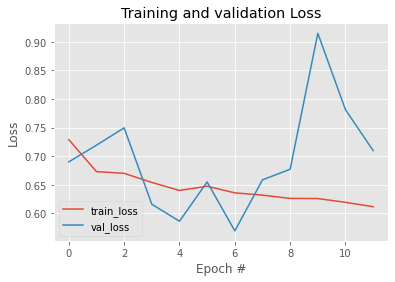

In [21]:
## plot figures

plot_loss(history)

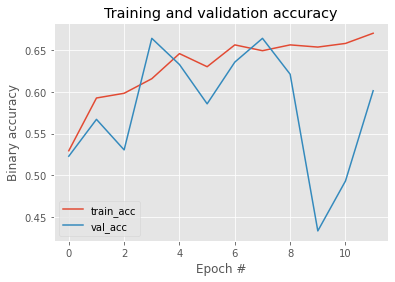

In [22]:
plot_accuracy(history)

#### The following curves are presented based on one batch of validation data. However, because one batch of validation data is not representative of all of the validation data, the actual threshold value is then chosen based on the curves plotted for all of the validation data. These curves below are for demo only

In [24]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
val_gen.reset()
valX, valY = val_gen.next()
pred_Y = model.predict(valX, batch_size = 64, verbose = True)

64/64 [==============================] - 1s 12ms/step


In [25]:
true_Y = valY

In [10]:
def plot_auc(t_y, p_y):

    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    auc = roc_auc_score(t_y, p_y)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return


def plot_prauc(t_y, p_y):
    
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    
    average_precision = average_precision_score(t_y, p_y)
    
    plt.figure()
    
    plt.plot(recall, precision, marker='.')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    # show the legend
    plt.legend(loc="lower right")
    # show the plot
    plt.show()
    
def plot_precision_recall_vs_threshold(t_y, p_y):

    precisions, recalls, thresholds = precision_recall_curve(t_y, p_y)
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
def plot_f1_vs_threshold(t_y, p_y):
    
    precisions, recalls, thresholds = precision_recall_curve(t_y, p_y)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    plt.figure(figsize=(8, 8))
    plt.title("F1 Scores as a function of the decision threshold")
    plt.plot(thresholds, f1_scores[:-1], "b--", label="F1")
    plt.ylabel("F1 Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
        
        

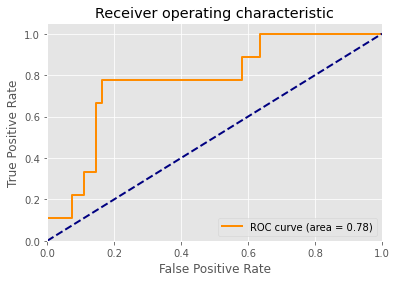

In [27]:
plot_auc(valY, pred_Y)

No handles with labels found to put in legend.


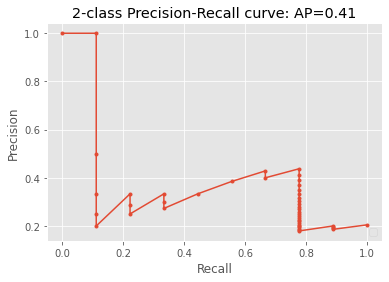

In [28]:
plot_prauc(valY, pred_Y)

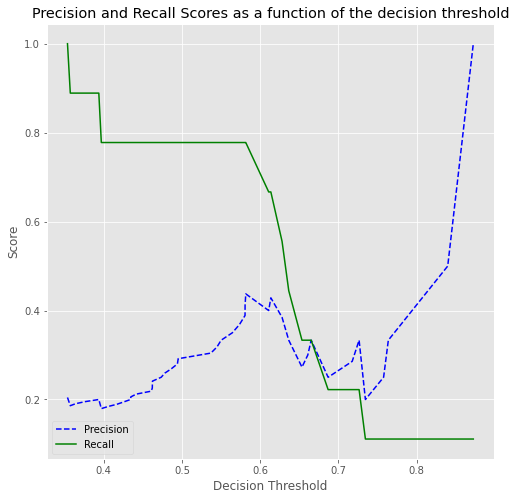

In [29]:
plot_precision_recall_vs_threshold(valY, pred_Y)

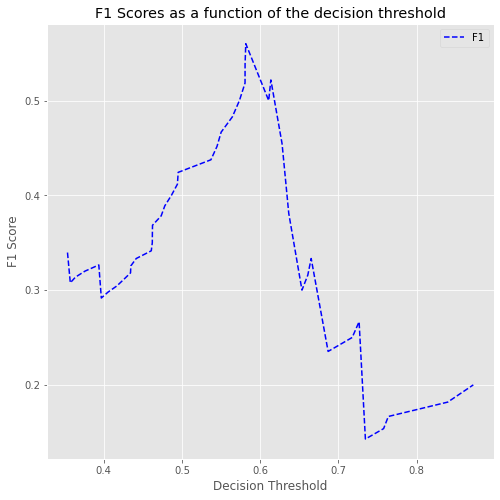

In [30]:
plot_f1_vs_threshold(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [32]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Find the threshold that maximises precision
precisions, recalls, thresholds = precision_recall_curve(valY, pred_Y)
print(np.argmax(precisions[:-1]))
i = thresholds[np.argmax(precisions[:-1])]
print (i)

# Find the threshold that maximises F1
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
i = thresholds[np.argmax(f1_scores[:-1]) - 1]
print(i)

43
0.8722389
0.5806565


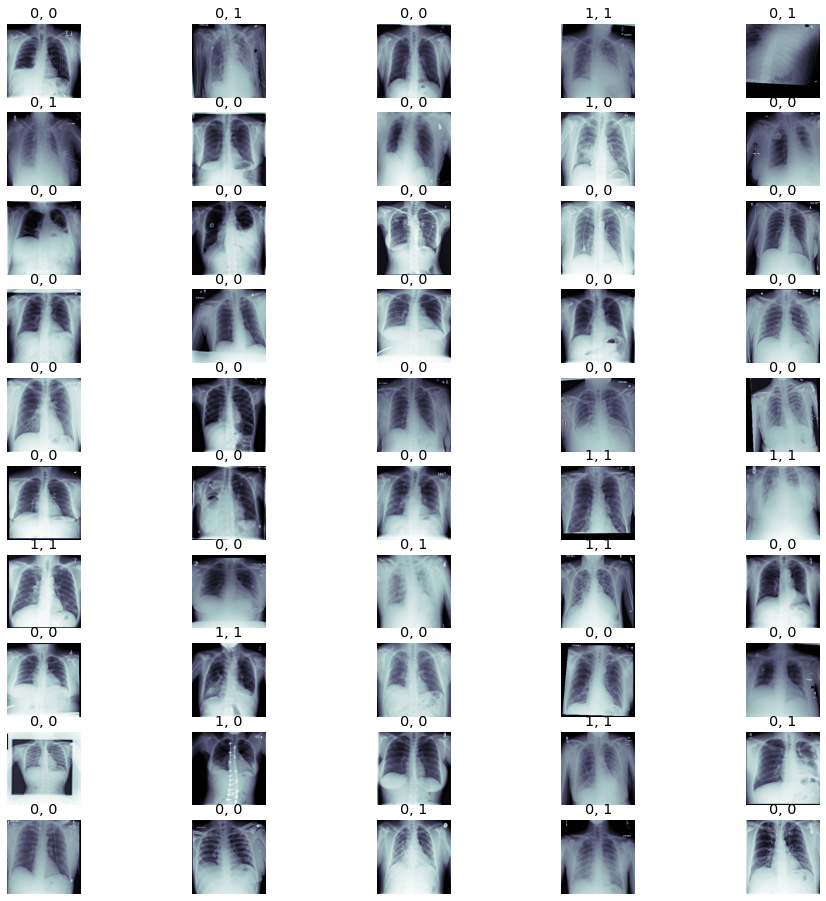

In [33]:
## Let's look at some examples of true vs. predicted with our best model based on F1 score: 

fig, m_axs = plt.subplots(10, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:50], valY[0:50], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.5806565:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.5806565: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [34]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

In [10]:
# Now we will test performance of our model on all validation data, not just (valX, valY)
model_path = "my_model.json" 
weight_path = "xray_class_my_model.best.hdf5"

json_file = open(model_path, "r") 
loaded_model_json = json_file.read() 
json_file.close() 
model = model_from_json(loaded_model_json) 
model.load_weights(weight_path)

val_gen.reset()

NameError: name 'val_gen' is not defined

In [32]:
len(val_gen)

27

In [33]:
# We go batch by batch and record actual labels and predictions for each batch.
# We could use model.predict_generator but for that to work, we would have to set shuffle = False in our image generator code.
# This was attempted but then each val_gen batch had either all 0's or all 1's which messed up training. 

val_Y_all = []
pred_Y_all = []
for i in range(len(val_gen) - 1):
    valX, valY = val_gen.next()
    pred_Y =  model.predict(valX, batch_size = 64, verbose = True)
    pred_Y_all.append(pred_Y)
    val_Y_all.append(valY)

64/64 [==============================] - 35s 546ms/step


In [34]:
pred_Y_flat = [item for sublist in pred_Y_all for item in sublist]
val_Y_flat = [item for sublist in val_Y_all for item in sublist]

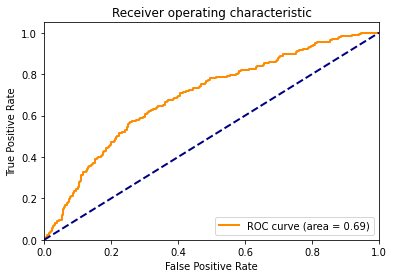

In [35]:
plot_auc(val_Y_flat, pred_Y_flat)

No handles with labels found to put in legend.


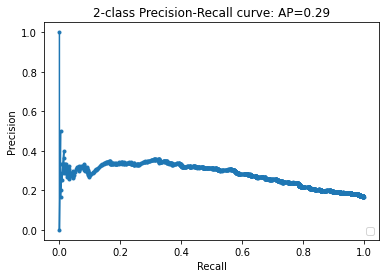

In [36]:
plot_prauc(val_Y_flat, pred_Y_flat)

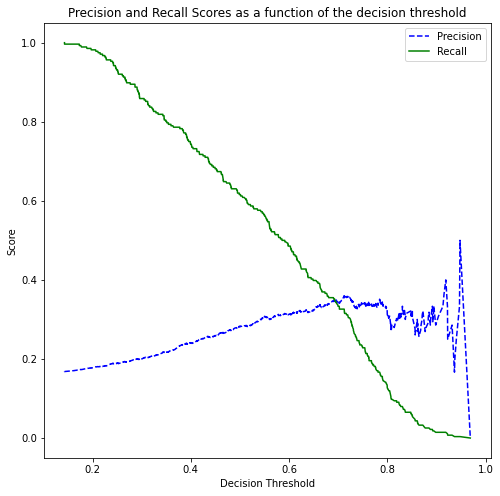

In [37]:
plot_precision_recall_vs_threshold(val_Y_flat, pred_Y_flat)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


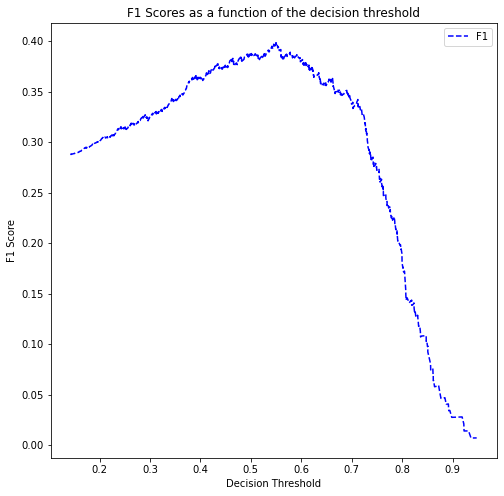

In [38]:
plot_f1_vs_threshold(val_Y_flat, pred_Y_flat)

In [39]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Find the threshold that maximises precision
precisions, recalls, thresholds = precision_recall_curve(valY, pred_Y)
print(np.argmax(precisions[:-1]))
i = thresholds[np.argmax(precisions[:-1])]
print (i)

# Find the threshold that maximises F1
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
i = thresholds[np.argmax(f1_scores[:-1]) - 1]
print(i) #30
print (thresholds[30])

60
0.91899514
0.50763667


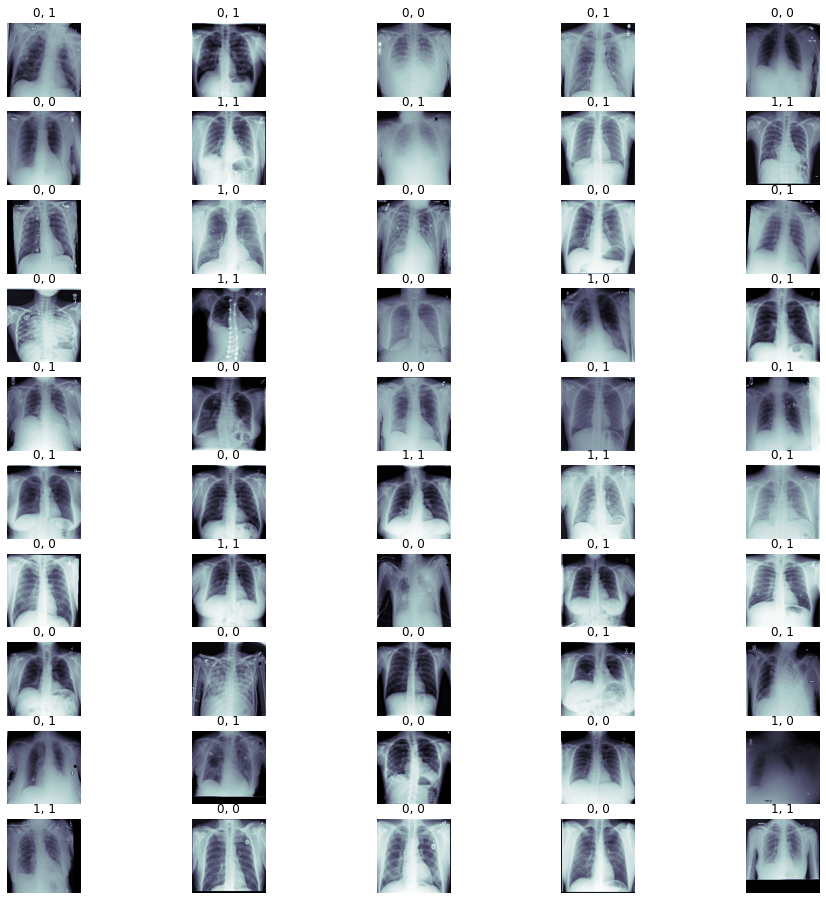

In [40]:
# We will take 0.50763667 as our threshold as this maximises the F1 score on our entire validation data
## Let's look at some examples of true vs. predicted with our best model: 

val_gen.reset()
valX, valY = val_gen.next()

fig, m_axs = plt.subplots(10, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:50], valY[0:50], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.50763667:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.50763667: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [42]:
# Let's calculate actual labels based on this threshold
pred_Y_actual = [1 if i > 0.50763667 else 0 for i in pred_Y_flat]


In [52]:
tn, fp, fn, tp = confusion_matrix(val_Y_flat, pred_Y_actual, labels=[1,0]).ravel()
precision = precision_score(val_Y_flat, pred_Y_actual)
f1_score = f1_score(val_Y_flat, pred_Y_actual)


In [53]:
sens = tp/(tp+fn)
spec = tn/(tn+fp)
print('Sensitivity: '+ str(sens))
print('Specificity: ' +str(spec))
print('Precision: ' +str(precision))
print('F1 score: ' +str(f1_score))

Sensitivity: 0.6945244956772334
Specificity: 0.6086956521739131
Precision: 0.28378378378378377
F1 score: 0.38709677419354843


In [11]:
# We will now label all validation data with our model predictions and check performance for pneumonia in the presence of comorbidities
model_path = "my_model.json" 
weight_path = "xray_class_my_model.best.hdf5"

json_file = open(model_path, "r") 
loaded_model_json = json_file.read() 
json_file.close() 
model = model_from_json(loaded_model_json) 
model.load_weights(weight_path)

threshold = 0.50763667
pneumonia_prob = []
val_imgs = val_data['path']
for imgfile in val_imgs:
    img = plt.imread(imgfile)
    this_img_mean = np.mean(img)
    this_img_std = np.std(img)
    grey_img = (img - this_img_mean)/this_img_std
    proc_img = np.resize(grey_img,(1,224,224,3))
    pred = model.predict(proc_img)
    if (pred > threshold):
            pneumonia = 1
    else:
            pneumonia = 0
    pneumonia_pred.append(pneumonia)



In [17]:
val_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,pneumonia_pred
41925,00010805_010.png,Consolidation|Pneumonia,10,10805,6,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,1,0,1,1
22198,00005892_001.png,Pneumonia,1,5892,61,F,PA,2626,2757,0.143,...,0,0,0,0,0,0,1,0,1,1
37738,00009925_036.png,Consolidation|Effusion|Infiltration|Mass|Nodul...,36,9925,56,M,PA,2992,2991,0.143,...,0,1,1,0,1,1,1,0,1,1
57802,00014320_021.png,Atelectasis|Pneumonia,21,14320,25,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,1,0,1,1
67272,00016607_033.png,Mass|Pneumonia,33,16607,64,M,AP,2500,2048,0.168,...,0,0,1,0,0,0,1,0,1,1


In [15]:
# Check scores for pneumonia with infiltration
val_Infil = val_data[val_data.Infiltration == 1]
val_true = val_Infil['pneumonia_class'].astype(int)
val_pred = val_Infil['pneumonia_pred']


tn, fp, fn, tp = confusion_matrix(val_true, val_pred, labels=[1,0]).ravel()
precision = precision_score(val_true, val_pred)
recall = recall_score(val_true, val_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print('Precision: ' +str(precision))
print('Recall: ' +str(recall))
print('F1 score: ' +str(f1))

Precision: 0.30327868852459017
Recall: 0.9823008849557522
F1 score: 0.46346555323590816


In [16]:
# Check scores for pneumonia with Effusion
val_Effusion = val_data[val_data.Effusion == 1]
val_true = val_Effusion['pneumonia_class'].astype(int)
val_pred = val_Effusion['pneumonia_pred']


tn, fp, fn, tp = confusion_matrix(val_true, val_pred, labels=[1,0]).ravel()
precision = precision_score(val_true, val_pred)
recall = recall_score(val_true, val_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print('Precision: ' +str(precision))
print('Recall: ' +str(recall))
print('F1 score: ' +str(f1))

Precision: 0.20689655172413793
Recall: 1.0
F1 score: 0.34285714285714286


In [17]:
# Check scores for pneumonia with Edema
val_Edema = val_data[val_data.Edema == 1]
val_true = val_Edema['pneumonia_class'].astype(int)
val_pred = val_Edema['pneumonia_pred']


tn, fp, fn, tp = confusion_matrix(val_true, val_pred, labels=[1,0]).ravel()
precision = precision_score(val_true, val_pred)
recall = recall_score(val_true, val_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print('Precision: ' +str(precision))
print('Recall: ' +str(recall))
print('F1 score: ' +str(f1))

Precision: 0.7311827956989247
Recall: 1.0
F1 score: 0.84472049689441


In [18]:
val_Atelectasis = val_data[val_data.Atelectasis == 1]
val_true = val_Atelectasis['pneumonia_class'].astype(int)
val_pred = val_Atelectasis['pneumonia_pred']


tn, fp, fn, tp = confusion_matrix(val_true, val_pred, labels=[1,0]).ravel()
precision = precision_score(val_true, val_pred)
recall = recall_score(val_true, val_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print('Precision: ' +str(precision))
print('Recall: ' +str(recall))
print('F1 score: ' +str(f1))

Precision: 0.2835820895522388
Recall: 0.9827586206896551
F1 score: 0.4401544401544401


In [19]:
val_Cardiomegaly = val_data[val_data.Cardiomegaly == 1]
val_true = val_Cardiomegaly['pneumonia_class'].astype(int)
val_pred = val_Cardiomegaly['pneumonia_pred']


tn, fp, fn, tp = confusion_matrix(val_true, val_pred, labels=[1,0]).ravel()
precision = precision_score(val_true, val_pred)
recall = recall_score(val_true, val_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print('Precision: ' +str(precision))
print('Recall: ' +str(recall))
print('F1 score: ' +str(f1))

Precision: 0.13725490196078433
Recall: 1.0
F1 score: 0.24137931034482762


In [20]:
val_Consolidation = val_data[val_data.Consolidation == 1]
val_true = val_Consolidation['pneumonia_class'].astype(int)
val_pred = val_Consolidation['pneumonia_pred']


tn, fp, fn, tp = confusion_matrix(val_true, val_pred, labels=[1,0]).ravel()
precision = precision_score(val_true, val_pred)
recall = recall_score(val_true, val_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print('Precision: ' +str(precision))
print('Recall: ' +str(recall))
print('F1 score: ' +str(f1))

Precision: 0.3068181818181818
Recall: 0.9642857142857143
F1 score: 0.4655172413793104


In [21]:
#Emphysema
val_Emphysema = val_data[val_data.Emphysema == 1]
val_true = val_Emphysema['pneumonia_class'].astype(int)
val_pred = val_Emphysema['pneumonia_pred']


tn, fp, fn, tp = confusion_matrix(val_true, val_pred, labels=[1,0]).ravel()
precision = precision_score(val_true, val_pred)
recall = recall_score(val_true, val_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print('Precision: ' +str(precision))
print('Recall: ' +str(recall))
print('F1 score: ' +str(f1))

Precision: 0.1891891891891892
Recall: 0.875
F1 score: 0.3111111111111111


In [27]:
# Mass
val_Mass = val_data[val_data.Mass == 1]
val_true = val_Mass['pneumonia_class'].astype(int)
val_pred = val_Mass['pneumonia_pred']


tn, fp, fn, tp = confusion_matrix(val_true, val_pred, labels=[1,0]).ravel()
precision = precision_score(val_true, val_pred)
recall = recall_score(val_true, val_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print('Precision: ' +str(precision))
print('Recall: ' +str(recall))
print('F1 score: ' +str(f1))

Precision: 0.20253164556962025
Recall: 1.0
F1 score: 0.3368421052631579


In [30]:
# Nodule
val_Nodule = val_data[val_data.Nodule == 1]
val_true = val_Nodule['pneumonia_class'].astype(int)
val_pred = val_Nodule['pneumonia_pred']


tn, fp, fn, tp = confusion_matrix(val_true, val_pred, labels=[1,0]).ravel()
precision = precision_score(val_true, val_pred)
recall = recall_score(val_true, val_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print('Precision: ' +str(precision))
print('Recall: ' +str(recall))
print('F1 score: ' +str(f1))

Precision: 0.1134020618556701
Recall: 1.0
F1 score: 0.2037037037037037


In [31]:
# Pleural thickening
val_Pleural = val_data[val_data.Pleural_Thickening == 1]
val_true = val_Pleural['pneumonia_class'].astype(int)
val_pred = val_Pleural['pneumonia_pred']


tn, fp, fn, tp = confusion_matrix(val_true, val_pred, labels=[1,0]).ravel()
precision = precision_score(val_true, val_pred)
recall = recall_score(val_true, val_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print('Precision: ' +str(precision))
print('Recall: ' +str(recall))
print('F1 score: ' +str(f1))

Precision: 0.1076923076923077
Recall: 1.0
F1 score: 0.19444444444444445


In [32]:
# Pneumothorax
val_Pneumothorax = val_data[val_data.Pneumothorax == 1]
val_true = val_Pneumothorax['pneumonia_class'].astype(int)
val_pred = val_Pneumothorax['pneumonia_pred']


tn, fp, fn, tp = confusion_matrix(val_true, val_pred, labels=[1,0]).ravel()
precision = precision_score(val_true, val_pred)
recall = recall_score(val_true, val_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print('Precision: ' +str(precision))
print('Recall: ' +str(recall))
print('F1 score: ' +str(f1))

Precision: 0.10344827586206896
Recall: 1.0
F1 score: 0.1875


In [44]:
# Pneumonia
val_Pneumonia_only = val_data[(val_data.Pneumonia == 1) & 
                              (val_data.Infiltration == 0) &
                              (val_data.Cardiomegaly == 0) &
                              (val_data.Atelectasis == 0) &
                              (val_data.Effusion == 0) &
                              (val_data.Edema == 0) &
                              (val_data.Consolidation == 0) &
                              (val_data.Emphysema == 0) &
                              (val_data.Fibrosis == 0) &
                              (val_data.Hernia == 0) &
                              (val_data.Mass == 0) &
                              (val_data.Nodule == 0) &
                              (val_data.Pleural_Thickening == 0) &
                              (val_data.Pneumothorax == 0) &
                              (val_data["No Finding"] == 0)
                             ]
val_true = val_Pneumonia_only['pneumonia_class'].astype(int)
val_pred = val_Pneumonia_only['pneumonia_pred']


tn, fp, fn, tp = confusion_matrix(val_true, val_pred, labels=[1,0]).ravel()
precision = precision_score(val_true, val_pred)
recall = recall_score(val_true, val_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print('Precision: ' +str(precision))
print('Recall: ' +str(recall))
print('F1 score: ' +str(f1))

Precision: 1.0
Recall: 0.9857142857142858
F1 score: 0.9928057553956835
